<a href="https://colab.research.google.com/github/m3sibti/DL_projects/blob/master/Keras_cyclegan_mw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cycle-GAN

Image-to-Image Unpaired Translation

## Imports

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage.interpolation
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image

## Prepare the dataset

In [2]:
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()

print('Training Samples ', x_train.shape)
print('Test Samples',x_test.shape)
x_data = np.vstack((x_train, x_test))
print('Combined Samples', x_data.shape)

4423680/4422102 [==============================] - 0s 0us/step
Training Samples  (60000, 28, 28)
Test Samples (10000, 28, 28)
Combined Samples (70000, 28, 28)


Find the mid point and rotate the other half to create a second domain Y against first half X

In [0]:
mid_point = int(x_data.shape[0]/2)

In [0]:
x_real = x_data[:mid_point]
x_real = x_real.reshape(-1, 28*28)
x_real = x_real.astype('float32')

In [0]:
x_rotated = x_data[mid_point:]
x_rotated = scipy.ndimage.interpolation.rotate(x_rotated, 90, axes=(1, 2))
x_rotated = x_rotated.reshape(-1, 28*28)

x_rotated = x_rotated.astype('float32')

In [6]:
x_real.shape, x_rotated.shape

((35000, 784), (35000, 784))

Visualize the Images

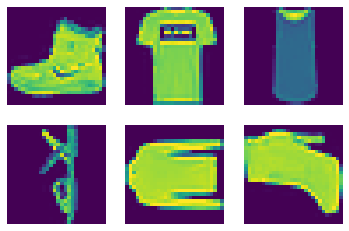

In [7]:
def show_images(x_real, x_rotated):
  fig, axs = plt.subplots(2, 3)
  [axi.set_axis_off() for axi in axs.ravel()]
  for i in range(3):
    x_img_real = x_real[i].reshape(28, 28)
    x_img_rotated = x_rotated[i].reshape(28, 28)
    axs[0][i].imshow(x_img_real)
    axs[1][i].imshow(x_img_rotated)

show_images(x_real, x_rotated)

Normalize the dataset and convert into single dataset object

In [0]:
x_real = x_real / 255.
x_rotated = x_rotated / 255.

In [0]:
data = tf.data.Dataset.from_tensor_slices((x_real, x_rotated))
data = data.shuffle(1024).batch(32).prefetch(16)

## Create Models

### Discriminators

In [0]:
Disc_A = models.Sequential([
                            keras.Input(shape=(784,)),
                            layers.Dense(128, activation='relu',
                                         kernel_initializer=keras.initializers.glorot_normal,
                                         bias_initializer=keras.initializers.glorot_normal),
                            layers.Dense(1, activation='sigmoid',
                                         kernel_initializer=keras.initializers.glorot_normal,
                                         bias_initializer=keras.initializers.glorot_normal),
])

Disc_B = models.Sequential([
                            keras.Input(shape=(784,)),
                            layers.Dense(128, activation='relu',
                                         kernel_initializer=keras.initializers.glorot_normal,
                                         bias_initializer=keras.initializers.glorot_normal),
                            layers.Dense(1, activation='sigmoid',
                                         kernel_initializer=keras.initializers.glorot_normal,
                                         bias_initializer=keras.initializers.glorot_normal),
])

In [11]:
print(Disc_A.summary())
print(Disc_B.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 100,609
Trainable params: 100,609
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 100,609
Trainable params: 100,609
Non-trainable params: 0
_________________________________________________________________
None


### Generators

In [0]:
Gen_AB = models.Sequential([
                            keras.Input(shape=(784,)),
                            layers.Dense(128, activation='relu',
                                         kernel_initializer=keras.initializers.glorot_normal,
                                         bias_initializer=keras.initializers.glorot_normal),
                            layers.Dense(784, activation='sigmoid',
                                         kernel_initializer=keras.initializers.glorot_normal,
                                         bias_initializer=keras.initializers.glorot_normal),
])

Gen_BA = models.Sequential([
                            keras.Input(shape=(784,)),
                            layers.Dense(128, activation='relu',
                                         kernel_initializer=keras.initializers.glorot_normal,
                                         bias_initializer=keras.initializers.glorot_normal),
                            layers.Dense(784, activation='sigmoid',
                                         kernel_initializer=keras.initializers.glorot_normal,
                                         bias_initializer=keras.initializers.glorot_normal),
])

In [13]:
print(Gen_AB.summary())
print(Gen_BA.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_5 (Dense)              (None, 784)               101136    
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_7 (Dense)              (None, 784)               101136    
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
_________________________________________________________________
None


## Override Training Step

In [0]:
class CycleGAN(models.Model):

  def __init__(self, disc_A, disc_B, gen_AB, gen_BA):
    super(CycleGAN, self).__init__()
    self.disc_A = disc_A
    self.disc_B = disc_B
    self.gen_AB = gen_AB
    self.gen_BA = gen_BA
    
  def compile(self, disc_A_opt, disc_B_opt, gen_AB_opt, gen_BA_opt,
              disc_A_loss, disc_B_loss, gen_AB_loss, gen_BA_loss):
    super(CycleGAN, self).compile()
    self.disc_A_opt = disc_A_opt
    self.disc_B_opt = disc_B_opt
    self.gen_AB_opt = gen_AB_opt
    self.gen_BA_opt = gen_BA_opt
    self.disc_A_loss = disc_A_loss
    self.disc_B_loss = disc_B_loss
    self.gen_AB_loss = gen_AB_loss
    self.gen_BA_loss = gen_BA_loss


  def train_step(self, X):
    x_A, x_B = X[0], X[1]
    bs = tf.shape(x_A)[0]

    # DISCRIMINATOR A to B Step
    ########################################
    x_BA = self.gen_BA(x_B)  # images B -> A
    # combine the real and fake images
    comb_A = tf.concat([x_A, x_BA], axis=0)
    labels_A = tf.concat([tf.ones((bs, 1)), tf.zeros((bs, 1))], axis=0)

    with tf.GradientTape() as tape_DiscA:
      discA_preds = self.disc_A(comb_A)
      discA_loss = self.disc_A_loss(labels_A, discA_preds)
    discA_grads = tape_DiscA.gradient(discA_loss, self.disc_A.trainable_weights)
    self.disc_A_opt.apply_gradients(zip(discA_grads, self.disc_A.trainable_weights))
    ######################################################################

    # DISCRIMINATOR B to A Step
    ########################################
    x_AB = self.gen_AB(x_A)  # images B -> A
    # combine the real and fake images
    comb_B = tf.concat([x_B, x_AB], axis=0)
    labels_B = tf.concat([tf.ones((bs, 1)), tf.zeros((bs, 1))], axis=0)

    with tf.GradientTape() as tape_DiscB:
      discB_preds = self.disc_B(comb_B)
      discB_loss = self.disc_B_loss(labels_B, discB_preds)
    discB_grads = tape_DiscB.gradient(discB_loss, self.disc_B.trainable_weights)
    self.disc_B_opt.apply_gradients(zip(discB_grads, self.disc_B.trainable_weights))
    ######################################################################

    # Total D loss
    # d_total = disA_loss + disB_loss

    # Image Reconstruction
    x_ABA = self.gen_BA(x_AB)
    x_BAB = self.gen_AB(x_BA)

    # Seems to be a problem here
    # GEN-AB
    #######################################################################
    with tf.GradientTape() as tape_GenA:
      gen_x_AB = self.gen_BA(x_B)
      discB_preds = self.disc_B(gen_x_AB)
      gA_loss = self.gen_AB_loss(discB_preds)
      
      rec_A_Loss = tf.reduce_mean(10*tf.abs(x_A - x_ABA))
      gA_loss += rec_A_Loss

    genAB_grads = tape_GenA.gradient(gA_loss, self.gen_AB.trainable_weights)
    self.gen_AB_opt.apply_gradients(zip(genAB_grads, self.gen_AB.trainable_weights))
    #######################################################################

    # Seems to be a problem here
    # GEN-BA
    #######################################################################
    with tf.GradientTape() as tape_GenB:
      gen_x_BA = self.gen_AB(x_A)
      discA_preds = self.disc_A(gen_x_BA)
      gB_loss = self.gen_BA_loss(discA_preds)
      
      rec_B_Loss = tf.reduce_mean(10*tf.abs(x_B - x_BAB))
      gB_loss += rec_B_Loss

    genBA_grads = tape_GenB.gradient(gB_loss, self.gen_BA.trainable_weights)
    self.gen_BA_opt.apply_gradients(zip(genBA_grads, self.gen_BA.trainable_weights))
    #######################################################################

    # Total Gen Loss
    # g_total = gA_loss + gB_loss

    return {'d_loss': discA_loss, 'g_loss':gA_loss}




## Training the model

In [0]:
model = CycleGAN(Disc_A, Disc_B, Gen_AB, Gen_BA)

#### Disc Losses

In [0]:
def disA_loss(real_labels, fake_labels):
  return tf.reduce_mean(
      tf.square(real_labels - tf.ones_like(real_labels)) + 
      tf.reduce_mean(tf.square(fake_labels))
  ) / 2.0
  
def disB_loss(real_labels, fake_labels):
  return tf.reduce_mean(
      tf.square(real_labels - tf.ones_like(real_labels)) + 
      tf.reduce_mean(tf.square(fake_labels))
  ) / 2.0

#### Gen Losses

In [0]:
def genA_loss(vals):
  return tf.reduce_mean(
      tf.square(vals) - tf.ones_like(vals)
  )

def genB_loss(vals):
  return tf.reduce_mean(
      tf.square(vals) - tf.ones_like(vals)
  )

#### Optimizers

In [0]:
opt_DA = keras.optimizers.Adam(0.0002)
opt_DB = keras.optimizers.Adam(0.0002)
opt_GAB = keras.optimizers.Adam(0.0002)
opt_GBA = keras.optimizers.Adam(0.0002)

## Compile Model

In [0]:
model.compile(
    opt_DA, opt_DB, opt_GAB, opt_GBA,
    disA_loss, disB_loss, genA_loss, genB_loss
)

In [20]:
model.fit(data, epochs=10)

Epoch 1/10


ValueError: ignored